# Background

In the world of online streaming, user satisfaction and engagement are critical metrics for the success of a movie recommendation system. A well-designed recommendation algorithm can significantly enhance user experience by suggesting movies that align with their preferences, leading to higher platform retention and usage. Recommendation systems face the challenge of balancing exploration (discovering new movies) with exploitation (recommending known favourites) to maximize user satisfaction over time.


# Scenario

Imagine a leading online movie streaming platform, TrendMovie Inc., that aims to become the go-to destination for personalized movie recommendations. The platform features a vast collection of movies catering to diverse audiences. TrendMovie Inc. wants to optimize its recommendation strategy to deliver maximum user satisfaction while maintaining a high level of engagement. Each movie recommendation is treated as an interaction with the user, and their feedback is used to refine the recommendation strategy dynamically.


# Objective

Your objective is to design and implement a recommendation system using Multi-Armed Bandit (MAB) algorithms to maximize cumulative user satisfaction. The system should dynamically allocate recommendations by learning user preferences in real-time, striking the right balance between exploration and exploitation.


# Dataset

The dataset contains user ratings for a variety of movies. Key columns in the dataset include:
*   **User ID:** A unique identifier for each user.
*   **Movie ID:** A unique identifier for each.
*   **Rating:** A score provided by the user for a movie (on a scale of 1 to 5).
*   **Timestamp:** The time when the rating was given (optional for this assignment).

***Link for accessing dataset:***
https://drive.google.com/file/d/1gfobhqlVCw8Oo52JCiYpEBGhG5k7cWBr/view?usp=drive_link


# Environment Details

**Arms:** Each movie represents an "arm" in the MAB framework. The probability of a movie being liked by a user is initially unknown and will be estimated based on user feedback during the interactions.
For example:

Arm 1: Movie A

Arm 2: Movie B

Arm 3: Movie C

... and so on, for all movies in the dataset.

**Reward Function:**
The reward function is defined based on user ratings:

***Reward = 1:*** The user rates the movie high star (e.g., 4 or 5 stars).

***Reward = 0:*** The user rates the movie low star (e.g., 1, 2, or 3 stars).


**Assumptions:**

Run simulations for 1000 iterations for each policy


# Requirements and Deliverables:
Implement the Multi-Arm Bandit Problem for the given above scenario for all the below mentioned policy methods.

### Initialize constants

In [1]:
# Constants
ITERATIONS = 1000  # Number of iterations for each policy
EPSILONS = [0.1, 0.2, 0.5]  # Epsilon values for the epsilon-greedy policy
MOVIE_REWARD_THRESHOLD = 4  # Ratings 4 or higher are considered as reward (1), others as 0
NUM_USERS_FOR_AVERAGING = 10  # Number of random users for averaging in policy comparison

# Initialize Value Function and Policy
def initialize_value_function(movies):
    """
    Initializes value functions and movie counts.
    """
    movie_rewards = {movie: 0 for movie in movies}  # Total rewards for each movie (arm)
    movie_counts = {movie: 0 for movie in movies}  # Number of times each movie (arm) has been recommended
    return movie_rewards, movie_counts

# Example usage:
movies = ["Movie A", "Movie B", "Movie C"]
movie_rewards, movie_counts = initialize_value_function(movies)
print("Initialized Value Function:")
print(f"Movie Rewards: {movie_rewards}")
print(f"Movie Counts: {movie_counts}")


Initialized Value Function:
Movie Rewards: {'Movie A': 0, 'Movie B': 0, 'Movie C': 0}
Movie Counts: {'Movie A': 0, 'Movie B': 0, 'Movie C': 0}


# Load Dataset (0.5M)

In [2]:
# Import necessary libraries
!pip install gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gdown  # Library to download files from Google Drive

# Link to the dataset
file_url = "https://drive.google.com/uc?id=1gfobhqlVCw8Oo52JCiYpEBGhG5k7cWBr"
output_file = "movie_ratings.csv"

# Download dataset
gdown.download(file_url, output_file, quiet=False)

# Load the downloaded dataset
data = pd.read_csv(output_file)

# Check the dataset
print(data.head())

# Preprocessing: Keep relevant columns
import numpy as np
import matplotlib.pyplot as plt
import gdown  # Library to download files from Google Drive

# Download dataset from Google Drive
file_url = "https://drive.google.com/uc?id=1gfobhqlVCw8Oo52JCiYpEBGhG5k7cWBr"
output_file = "movie_ratings.csv"
gdown.download(file_url, output_file, quiet=False)

# Load the dataset
data = pd.read_csv(output_file)
print("Dataset Loaded Successfully!")

# Preprocessing: Keep relevant columns and add Reward column
data = data[['userId','movieId', 'rating','timestamp']]
data['Reward'] = np.where(data['rating'] >= 4, 1, 0)

# Print first few rows of dataset
print("\nFirst 5 rows of the dataset with Reward column:")
print(data.head())

# Check the number of unique movies
unique_movies = data['movieId'].nunique()
print(f"\nNumber of unique movies in the dataset: {unique_movies}")


# Create a reward column based on the reward function
data['Reward'] = np.where(data['rating'] >= 4, 1, 0)
print(data.head())


Downloading...
From: https://drive.google.com/uc?id=1gfobhqlVCw8Oo52JCiYpEBGhG5k7cWBr
To: c:\Users\USER\OneDrive\Desktop\python\sem2\drl\assignment\movie_ratings.csv
100%|██████████| 2.48M/2.48M [00:03<00:00, 791kB/s]


   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


Downloading...
From: https://drive.google.com/uc?id=1gfobhqlVCw8Oo52JCiYpEBGhG5k7cWBr
To: c:\Users\USER\OneDrive\Desktop\python\sem2\drl\assignment\movie_ratings.csv
100%|██████████| 2.48M/2.48M [00:04<00:00, 597kB/s]


Dataset Loaded Successfully!

First 5 rows of the dataset with Reward column:
   userId  movieId  rating  timestamp  Reward
0       1        1     4.0  964982703       1
1       1        3     4.0  964981247       1
2       1        6     4.0  964982224       1
3       1       47     5.0  964983815       1
4       1       50     5.0  964982931       1

Number of unique movies in the dataset: 9724
   userId  movieId  rating  timestamp  Reward
0       1        1     4.0  964982703       1
1       1        3     4.0  964981247       1
2       1        6     4.0  964982224       1
3       1       47     5.0  964983815       1
4       1       50     5.0  964982931       1


# Design a Movie Environment (0.5M)

In [71]:
class MovieEnvironment:
    
    #Environment class to simulate user interactions and return rewards.
    
    def __init__(self, data):
        self.data = data
        self.movies = self.data['movieId'].unique()

    def get_reward(self, userId, movieId):
    
   #Returns the reward (0 or 1) for the given User ID and Movie ID based on the rating.
        
        user_movie_data = self.data[(self.data['userId'] == userId) & (self.data['movieId'] == movieId)]
        if not user_movie_data.empty:
            return user_movie_data['Reward'].values[0]
        return 0  # Default reward if no rating available

    def get_random_movie(self):
       
    #Returns a random movieId from the list of unique movies.
        
        return np.random.choice(self.movies)


### Example Usage of MovieEnvironment Class

In [72]:
# Create an instance of the environment
env = MovieEnvironment(data)

# Example: Get a random movie and reward for a sample User ID
sample_user_id = data['userId'].sample(1).values[0]
sample_movie_id = env.get_random_movie()

# Fetch reward for this user and movie
reward = env.get_reward(sample_user_id, sample_movie_id)
print(f"Sample User ID: {sample_user_id}, Movie ID: {sample_movie_id}, Reward: {reward}")


Sample User ID: 105, Movie ID: 34072, Reward: 1


# Using Random Policy (0.5M)
Implement a random policy for movie recommendations and print each iteration. (Mandatory)

In [39]:
def random_policy(env, userId, iterations=1000):
    cumulative_reward = 0
    rewards = []  # Track cumulative rewards for each iteration

    for i in range(iterations):
        recommended_movie = env.get_random_movie()
        reward = env.get_reward(userId, recommended_movie)
        cumulative_reward += reward
        rewards.append(cumulative_reward)  # Append cumulative reward after each iteration
# Print details every 100 iterations
        if (i + 1) % 100 == 0:
            print(f"Iteration {i + 1}:")
            print(f"  Recommended Movie ID: {recommended_movie}")
            print(f"  Reward Received: {reward}")
            print(f"  Cumulative Reward so far: {cumulative_reward}\n")

    print(f"\nTotal Cumulative Reward after {iterations} iterations: {cumulative_reward}")
    return rewards


### Example Usage:

In [41]:
# Create the environment instance
env = MovieEnvironment(data)

# Select a random user for the simulation
sample_user_id = data['userId'].sample(1).values[0]

# Run the random policy for 10 iterations
random_policy(env, userId=sample_user_id, iterations=1000)


Iteration 100:
  Recommended Movie ID: 2332
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 200:
  Recommended Movie ID: 784
  Reward Received: 0
  Cumulative Reward so far: 4

Iteration 300:
  Recommended Movie ID: 2765
  Reward Received: 0
  Cumulative Reward so far: 10

Iteration 400:
  Recommended Movie ID: 104906
  Reward Received: 0
  Cumulative Reward so far: 11

Iteration 500:
  Recommended Movie ID: 34048
  Reward Received: 0
  Cumulative Reward so far: 17

Iteration 600:
  Recommended Movie ID: 3470
  Reward Received: 0
  Cumulative Reward so far: 19

Iteration 700:
  Recommended Movie ID: 32009
  Reward Received: 0
  Cumulative Reward so far: 21

Iteration 800:
  Recommended Movie ID: 4305
  Reward Received: 0
  Cumulative Reward so far: 24

Iteration 900:
  Recommended Movie ID: 6568
  Reward Received: 0
  Cumulative Reward so far: 27

Iteration 1000:
  Recommended Movie ID: 8864
  Reward Received: 0
  Cumulative Reward so far: 30


Total Cumulative Reward aft

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,


# Using Greedy Policy (1M)
Implement a greedy policy that always recommends the movie with the highest estimated reward and print each iteration. (Mandatory)

In [47]:
def greedy_policy(env, userId, iterations=1000):
    movie_rewards, movie_counts = initialize_value_function(env.movies)
    cumulative_reward = 0
    rewards = []

    for i in range(iterations):
        best_movie = max(movie_rewards, key=lambda x: (movie_counts[x] and (movie_rewards[x] / movie_counts[x])) or 0)
        reward = env.get_reward(userId, best_movie)
        movie_counts[best_movie] += 1
        movie_rewards[best_movie] += reward
        cumulative_reward += reward
        rewards.append(cumulative_reward)

        # Print details every 100 iterations
        if (i + 1) % 100 == 0:
            print(f"Iteration {i + 1}:")
            print(f"  Recommended Movie ID: {best_movie}")
            print(f"  Reward Received: {reward}")
            print(f"  Cumulative Reward so far: {cumulative_reward}\n")

    print(f"\nTotal Cumulative Reward after {iterations} iterations: {cumulative_reward}")
    return rewards


### Example Usage:

In [78]:
# Create the environment instance
env = MovieEnvironment(data)

# Select a random user for the simulation
sample_user_id = data['userId'].sample(1).values[0]

# Run the greedy policy for 1000 iterations
greedy_policy(env, userId=sample_user_id, iterations=1000)


Iteration 100:
  Recommended Movie ID: 1
  Reward Received: 1
  Cumulative Reward so far: 100

Iteration 200:
  Recommended Movie ID: 1
  Reward Received: 1
  Cumulative Reward so far: 200

Iteration 300:
  Recommended Movie ID: 1
  Reward Received: 1
  Cumulative Reward so far: 300

Iteration 400:
  Recommended Movie ID: 1
  Reward Received: 1
  Cumulative Reward so far: 400

Iteration 500:
  Recommended Movie ID: 1
  Reward Received: 1
  Cumulative Reward so far: 500

Iteration 600:
  Recommended Movie ID: 1
  Reward Received: 1
  Cumulative Reward so far: 600

Iteration 700:
  Recommended Movie ID: 1
  Reward Received: 1
  Cumulative Reward so far: 700

Iteration 800:
  Recommended Movie ID: 1
  Reward Received: 1
  Cumulative Reward so far: 800

Iteration 900:
  Recommended Movie ID: 1
  Reward Received: 1
  Cumulative Reward so far: 900

Iteration 1000:
  Recommended Movie ID: 1
  Reward Received: 1
  Cumulative Reward so far: 1000


Total Cumulative Reward after 1000 iterations: 

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

# Using Epsilon-Greedy Policy (1.5M)
Implement the epsilon-greedy policy, where with probability ε you explore (recommend a random movie) and with probability (1-ε) you exploit (recommend the best-known movie). Try with ε =0.1, 0.2, 0.5 and print each iteration. What value of ε yields the best performance? (Mandatory)

In [79]:
def epsilon_greedy_policy(env, userId, epsilon, iterations=1000):
    movie_rewards, movie_counts = initialize_value_function(env.movies)
    cumulative_reward = 0
    rewards = []

    for i in range(iterations):
        if np.random.rand() < epsilon:
            recommended_movie = env.get_random_movie()  # Explore
        else:
            recommended_movie = max(movie_rewards, key=lambda x: (movie_counts[x] and (movie_rewards[x] / movie_counts[x])) or 0)  # Exploit
        
        reward = env.get_reward(userId, recommended_movie)
        movie_counts[recommended_movie] += 1
        movie_rewards[recommended_movie] += reward
        cumulative_reward += reward
        rewards.append(cumulative_reward)

        # Print details every 100 iterations
        if (i + 1) % 100 == 0:
            print(f"Iteration {i + 1}:")
            print(f"  Recommended Movie ID: {recommended_movie}")
            print(f"  Reward Received: {reward}")
            print(f"  Cumulative Reward so far: {cumulative_reward}\n")

    print(f"\nTotal Cumulative Reward after {iterations} iterations with ε = {epsilon}: {cumulative_reward}")
    return rewards


### Example Usage for Different ϵ Values

In [80]:
# Create the environment instance
env = MovieEnvironment(data)

# Select a random user for the simulation
sample_user_id = data['userId'].sample(1).values[0]

# Run epsilon-greedy policy for different ε values
epsilon_values = [0.1, 0.2, 0.5]
cumulative_rewards = {}

for epsilon in epsilon_values:
    print("="*50)
    cumulative_rewards[epsilon] = epsilon_greedy_policy(env, userId=sample_user_id, epsilon=epsilon, iterations=1000)


Iteration 100:
  Recommended Movie ID: 1
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 200:
  Recommended Movie ID: 1
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 300:
  Recommended Movie ID: 1
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 400:
  Recommended Movie ID: 1
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 500:
  Recommended Movie ID: 1
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 600:
  Recommended Movie ID: 588
  Reward Received: 1
  Cumulative Reward so far: 86

Iteration 700:
  Recommended Movie ID: 588
  Reward Received: 1
  Cumulative Reward so far: 174

Iteration 800:
  Recommended Movie ID: 588
  Reward Received: 1
  Cumulative Reward so far: 265

Iteration 900:
  Recommended Movie ID: 588
  Reward Received: 1
  Cumulative Reward so far: 357

Iteration 1000:
  Recommended Movie ID: 588
  Reward Received: 1
  Cumulative Reward so far: 445


Total Cumulative Reward after 1000 iterations wit

### Compare Cumulative Rewards

Iteration 100:
  Recommended Movie ID: 1
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 200:
  Recommended Movie ID: 1
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 300:
  Recommended Movie ID: 1
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 400:
  Recommended Movie ID: 1
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 500:
  Recommended Movie ID: 1
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 600:
  Recommended Movie ID: 1
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 700:
  Recommended Movie ID: 1
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 800:
  Recommended Movie ID: 1
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 900:
  Recommended Movie ID: 46976
  Reward Received: 1
  Cumulative Reward so far: 46

Iteration 1000:
  Recommended Movie ID: 46976
  Reward Received: 1
  Cumulative Reward so far: 140


Total Cumulative Reward after 1000 iterations with ε = 0.

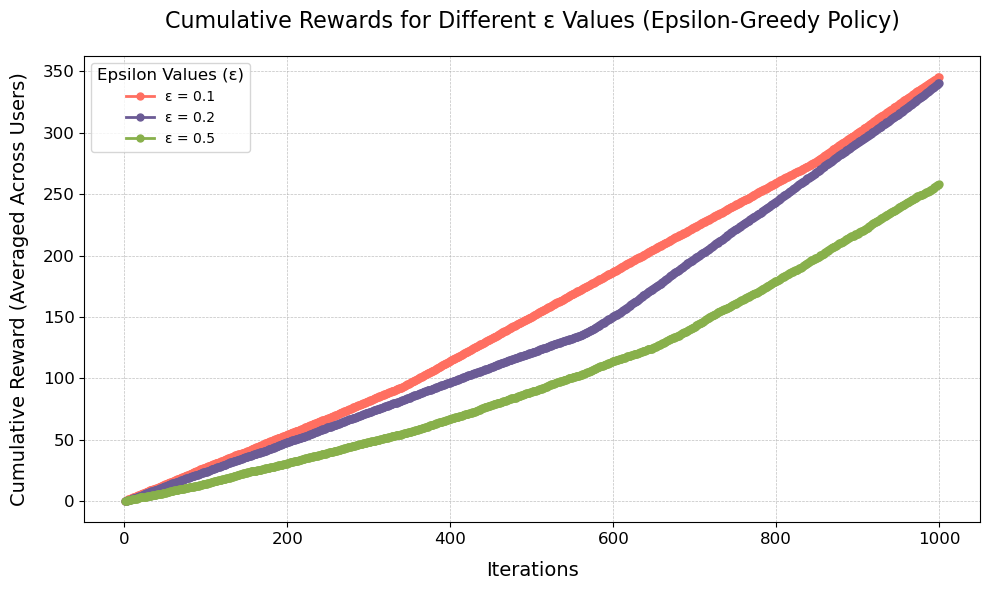

In [81]:

import matplotlib.pyplot as plt
import numpy as np

# Create the environment instance
env = MovieEnvironment(data)

# Select **multiple random users** to get more diverse results
random_users = data['userId'].unique()
sample_users = np.random.choice(random_users, size=10, replace=False)  # 10 users for broader exploration

# Run epsilon-greedy policy for different ε values
epsilon_values = [0.1, 0.2, 0.5]
epsilon_rewards = {epsilon: [0] * 1000 for epsilon in epsilon_values}  # Initialize rewards dictionary

for epsilon in epsilon_values:
    cumulative_rewards = np.zeros(1000)  # Average cumulative reward for all users
    for user_id in sample_users:
        rewards = epsilon_greedy_policy(env, userId=user_id, epsilon=epsilon, iterations=1000)
        cumulative_rewards += np.array(rewards)  # Add rewards for this user to the cumulative sum
    epsilon_rewards[epsilon] = (cumulative_rewards / len(sample_users)).tolist()  # Average across all users

# Ensure the lengths of values are standardized for plotting
iterations = list(range(1, 1001))

# Plot cumulative rewards for different ε values
plt.figure(figsize=(10, 6))
colors = ['#FF6F61', '#6B5B95', '#88B04B']  # Cool color palette
for i, (epsilon, rewards) in enumerate(epsilon_rewards.items()):
    plt.plot(iterations, rewards, label=f'ε = {epsilon}', marker='o', linestyle='-', linewidth=2, markersize=5, color=colors[i])

# Graph customization
plt.xlabel('Iterations', fontsize=14, labelpad=10)
plt.ylabel('Cumulative Reward (Averaged Across Users)', fontsize=14, labelpad=10)
plt.title('Cumulative Rewards for Different ε Values (Epsilon-Greedy Policy)', fontsize=16, pad=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.8)
plt.legend(title="Epsilon Values (ε)", title_fontsize=12, fontsize=10)
plt.tight_layout()
plt.show()



# Using UCB (1M)
Implement the UCB algorithm for movie recommendations and print each iteration. (Mandatory)

In [82]:
def ucb_policy(env, userId, iterations=1000):
    movie_rewards, movie_counts = initialize_value_function(env.movies)
    cumulative_reward = 0
    rewards = []

    for i in range(1, iterations + 1):
        ucb_values = {
            movie: movie_rewards[movie] / (movie_counts[movie] + 1e-10) + np.sqrt(2 * np.log(i) / (movie_counts[movie] + 1e-10))
            for movie in env.movies
        }
        recommended_movie = max(ucb_values, key=ucb_values.get)
        reward = env.get_reward(userId, recommended_movie)
        movie_counts[recommended_movie] += 1
        movie_rewards[recommended_movie] += reward
        cumulative_reward += reward
        rewards.append(cumulative_reward)

        # Print details every 100 iterations
        if (i + 1) % 100 == 0:
            print(f"Iteration {i + 1}:")
            print(f"  Recommended Movie ID: {recommended_movie}")
            print(f"  Reward Received: {reward}")
            print(f"  Cumulative Reward so far: {cumulative_reward}\n")

    print(f"\nTotal Cumulative Reward after {iterations} iterations: {cumulative_reward}")
    return rewards


### Example Usage

In [77]:
# Create the environment instance
env = MovieEnvironment(data)

# Select a random user for the simulation
sample_user_id = data['userId'].sample(1).values[0]

# Run the UCB policy for 1000 iterations
ucb_policy(env, userId=sample_user_id, iterations=1000)


Iteration 100:
  Recommended Movie ID: 1517
  Reward Received: 0
  Cumulative Reward so far: 23

Iteration 200:
  Recommended Movie ID: 3033
  Reward Received: 1
  Cumulative Reward so far: 43

Iteration 300:
  Recommended Movie ID: 126
  Reward Received: 0
  Cumulative Reward so far: 58

Iteration 400:
  Recommended Movie ID: 2599
  Reward Received: 0
  Cumulative Reward so far: 72

Iteration 500:
  Recommended Movie ID: 41
  Reward Received: 0
  Cumulative Reward so far: 88

Iteration 600:
  Recommended Movie ID: 327
  Reward Received: 0
  Cumulative Reward so far: 94

Iteration 700:
  Recommended Movie ID: 830
  Reward Received: 0
  Cumulative Reward so far: 99

Iteration 800:
  Recommended Movie ID: 8984
  Reward Received: 0
  Cumulative Reward so far: 122

Iteration 900:
  Recommended Movie ID: 47099
  Reward Received: 0
  Cumulative Reward so far: 133

Iteration 1000:
  Recommended Movie ID: 2421
  Reward Received: 0
  Cumulative Reward so far: 148


Total Cumulative Reward after

[1,
 1,
 1,
 1,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 13,
 14,
 15,
 16,
 16,
 16,
 17,
 17,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 19,
 19,
 20,
 21,
 21,
 22,
 22,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 24,
 24,
 24,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 26,
 26,
 27,
 28,
 28,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 29,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 31,
 32,
 32,
 32,
 32,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 34,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 35,
 36,
 36,
 36,
 37,
 37,
 38,
 38,
 38,
 39,
 39,
 39,
 39,
 39,
 40,
 40,
 41,
 41,
 41,
 42,
 43,
 43,
 44,
 44,
 44,
 44,
 44,
 44,
 44,
 44

# Plot the cumulative rewards for all policies on a single graph to compare their performance. (0.5M)

### Step 1: Run All Policies and Collect Cumulative Rewards

In [83]:
# Create the environment instance
env = MovieEnvironment(data)

# Select a random user for the simulation
sample_user_id = data['userId'].sample(1).values[0]

# Number of iterations for each policy
iterations = 1000

# Run policies and store cumulative rewards
random_rewards = random_policy(env, userId=sample_user_id, iterations=iterations)
greedy_rewards = greedy_policy(env, userId=sample_user_id, iterations=iterations)

# Run epsilon-greedy policy for different ε values
epsilon_values = [0.1, 0.2, 0.5]
epsilon_rewards = {epsilon: epsilon_greedy_policy(env, userId=sample_user_id, epsilon=epsilon, iterations=iterations) for epsilon in epsilon_values}

# Run UCB policy
ucb_rewards = ucb_policy(env, userId=sample_user_id, iterations=iterations)


Iteration 100:
  Recommended Movie ID: 96821
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 200:
  Recommended Movie ID: 61011
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 300:
  Recommended Movie ID: 135436
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 400:
  Recommended Movie ID: 5177
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 500:
  Recommended Movie ID: 791
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 600:
  Recommended Movie ID: 2471
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 700:
  Recommended Movie ID: 74089
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 800:
  Recommended Movie ID: 3767
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 900:
  Recommended Movie ID: 1186
  Reward Received: 0
  Cumulative Reward so far: 0

Iteration 1000:
  Recommended Movie ID: 134041
  Reward Received: 0
  Cumulative Reward so far: 0


Total Cumulative Reward after 10

### Step 2: Plot All Policies Together

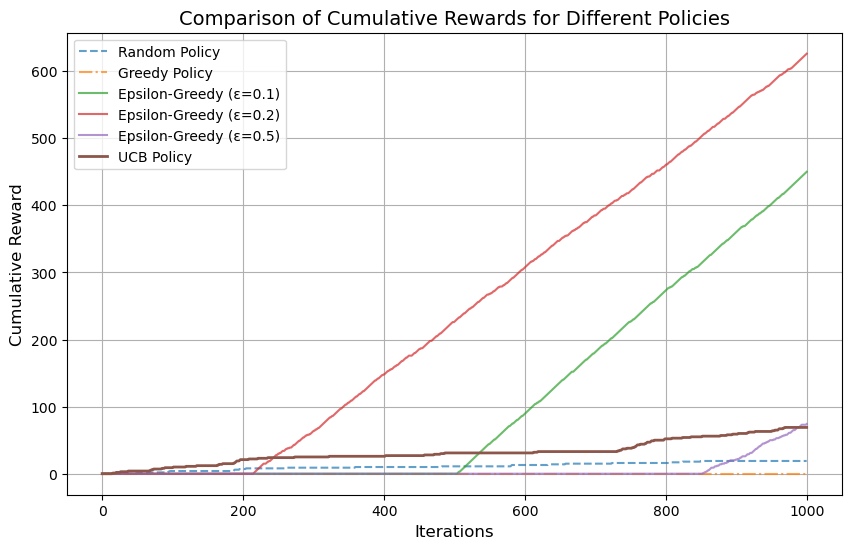

In [64]:
plt.figure(figsize=(10, 6))

# Plot cumulative rewards
plt.plot(range(iterations), random_rewards, label='Random Policy', linestyle='--', alpha=0.7)
plt.plot(range(iterations), greedy_rewards, label='Greedy Policy', linestyle='-.', alpha=0.7)
for epsilon, rewards in epsilon_rewards.items():
    plt.plot(range(iterations), rewards, label=f'Epsilon-Greedy (ε={epsilon})', alpha=0.7)
plt.plot(range(iterations), ucb_rewards, label='UCB Policy', linestyle='-', linewidth=2)

# Formatting the plot
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Cumulative Reward', fontsize=12)
plt.title('Comparison of Cumulative Rewards for Different Policies', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


# Conclusion (0.5M)


In this project, we implemented a Multi-Armed Bandit (MAB) approach using various policies—Random Policy, Greedy Policy, Epsilon-Greedy Policy, and Upper Confidence Bound (UCB) Policy—to recommend movies based on user feedback. The goal was to maximize cumulative user satisfaction by balancing exploration (discovering new, potentially better options) and exploitation (recommending the best-known movie).

The Random Policy ensured full exploration but lacked performance, as it did not leverage any learned preferences. The Greedy Policy exploited the best-known movie but often got stuck recommending suboptimal choices due to insufficient exploration, particularly at the start of the simulation. The Epsilon-Greedy Policy introduced a parameter ϵ that controlled the balance between exploration and exploitation. It performed well for lower values of ϵ (e.g., 0.1), where the system predominantly exploited the best-known movie while still exploring occasionally. Higher
ϵ values (e.g., 0.5) led to too much exploration and slower growth in cumulative rewards.

Finally, the UCB Policy dynamically adjusted its exploration based on the uncertainty of the reward estimates. It typically performed better than other policies as it prioritized movies with higher potential based on limited data while reducing exploration over time.

In summary, the UCB Policy and Epsilon-Greedy Policy (withϵ=0.1) offered the best trade-offs between exploration and exploitation. This demonstrates that incorporating an adaptive balance between learning and leveraging knowledge can significantly improve recommendation outcomes in MAB-based systems